In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

## Let's start by loading the data into a DataFrame and doing basic exploration

In [33]:
loans_filename = 'data/loans.csv'
loans_df = pd.read_csv(loans_filename, header=None, names=['loan_amount', 'address', 'created_at', 'funded_at']
                      ,infer_datetime_format=True, parse_dates=['created_at', 'funded_at'])

In [34]:
loans_df.head()

,loan_amount,address,created_at,funded_at
0,568705.0,"22226 Brookpine, Mission Viejo CA 92692",2016-12-20 07:16:04.778800+00:00,NaT
1,413165.0,"124 Vignolia Court, Roseville CA 95747",2016-10-11 20:35:19.951835+00:00,2016-11-07 00:00:00+00:00
2,584083.0,"13909 Via Del Jamul Dr, Jamul CA 91935",2017-08-08 03:23:04.349419+00:00,NaT
3,258680.0,"13209 N Mayfair Ln, Spokane WA 99208",2017-05-25 19:06:01.525985+00:00,NaT
4,170180.0,"205 Cottontail Ln, Elkin NC 28621",2017-03-02 19:40:13.319275+00:00,NaT


In [35]:
loans_df.dtypes

loan_amount                float64
address                     object
created_at     datetime64[ns, UTC]
funded_at      datetime64[ns, UTC]
dtype: object

In [36]:
loans_df.shape

(5143, 4)

In [37]:
loans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5143 entries, 0 to 5142
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   loan_amount  5143 non-null   float64            
 1   address      5143 non-null   object             
 2   created_at   5143 non-null   datetime64[ns, UTC]
 3   funded_at    1055 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](2), float64(1), object(1)
memory usage: 160.8+ KB


## Now let's explore the individual fields (look for outliers, standardize, etc)

### loan_amount 

In [38]:
loans_df.loan_amount.describe().apply(lambda x: format(x, 'f'))

count        5143.000000
mean       382389.442738
std       1271107.564632
min             9.000000
25%        216656.500000
50%        317937.000000
75%        421659.000000
max      57762492.000000
Name: loan_amount, dtype: object

<AxesSubplot:>

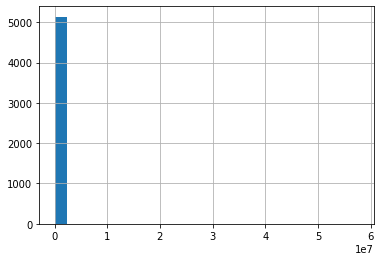

In [39]:
loans_df.loan_amount.hist(bins=25)

Looks like there are some outliers on the high and low end of loan amount.
Let's see what the histogram looks like and how many rows are removed if
removing the top .1% and bottom .5% of loan data. This corrsponds to loan amounts over 2.36M
and under 35k

In [40]:
q999 = loans_df.loan_amount.quantile(0.999)
q005 = loans_df.loan_amount.quantile(0.005)

loans_df = loans_df[loans_df.loan_amount <= q999]
loans_df = loans_df[loans_df.loan_amount >= q005]
loans_df.shape

(5112, 4)

We removed 5143 - 5112 = potential outlier loan_amounts from the dataset. Manual inspection of a few of
the removed outliers can occur to deicde whether to include in future analyses.
The distribution is more normal now, with an expected right skew

<AxesSubplot:>

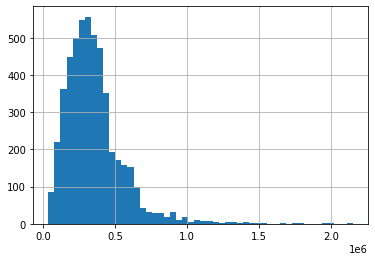

In [41]:
loans_df.loan_amount.hist(bins=50)

### Created At & Funded At

In [42]:
loans_df.created_at.describe()

/var/folders/mt/ktdd7wvn6zjck2b0lwgqdpx80000gn/T/ipykernel_15983/3845017256.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  loans_df.created_at.describe()


count                                 5112
unique                                5112
top       2016-12-20 07:16:04.778800+00:00
freq                                     1
first     2016-02-23 02:25:11.436000+00:00
last      2017-12-13 20:18:56.307206+00:00
Name: created_at, dtype: object

<AxesSubplot:>

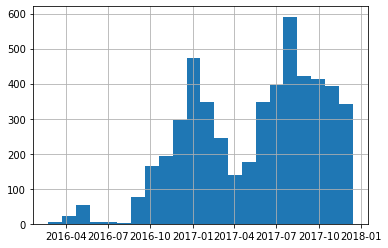

In [43]:
loans_df.created_at.hist(bins=22)  # one bin for every month in the dataset

In [44]:
#remove loans created before Jun 2016
loans_df = loans_df[loans_df.created_at >= '2016-06-01']
loans_df.shape

(5025, 4)

There are very few loans made before September 2016, so I will remove those. Looking at
loan conversion stats on a monthly basis will be misleading for these months.

Also of note, it appears summer is a more popular time for loan applications

Overall 1055 of the 5112 loans were converted (20.6%)

In [46]:
# Let's create a time_to_conversion field so we can analyze change in this value monthly
loans_df['time_to_conversion'] = (loans_df.funded_at - loans_df.created_at).dt.days

## Analysis: Group the data by month and look at Conversion Rate, Time to Conversion, and Number of Loan Applications By Month

In [47]:
# group by month using the loan created date and calculate some stats off the grouped data
def group_functions(x):
    d = {}
    d['loan_amount_sum'] = x['loan_amount'].sum()
    d['loan_app_count'] = x['loan_amount'].count()
    d['loan_funded_count'] = x['funded_at'].count()
    d['loan_app_amount_avg'] = x['loan_amount'].mean()
    d['conversion_rate'] = max(x['funded_at'].count() /x['created_at'].count(), 0)
    d['time_to_conversion_avg'] = x['time_to_conversion'].mean()
    return pd.Series(d, index=['loan_amount_sum', 'loan_app_count', 'loan_funded_count', 
                               'loan_app_amount_avg', 'conversion_rate', 'time_to_conversion_avg'])

monthly = loans_df.created_at.dt.to_period('M')
monthly_loan_stats = loans_df.groupby(monthly).apply(group_functions)
monthly_loan_stats.index.rename('created_at_month', inplace=True)

/Users/paulsingman/dev/pandas-on-spark/venv/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


<AxesSubplot:title={'center':'Converison Rate of Loan Apps by Month'}, xlabel='created_at_month', ylabel='conversion_rate'>

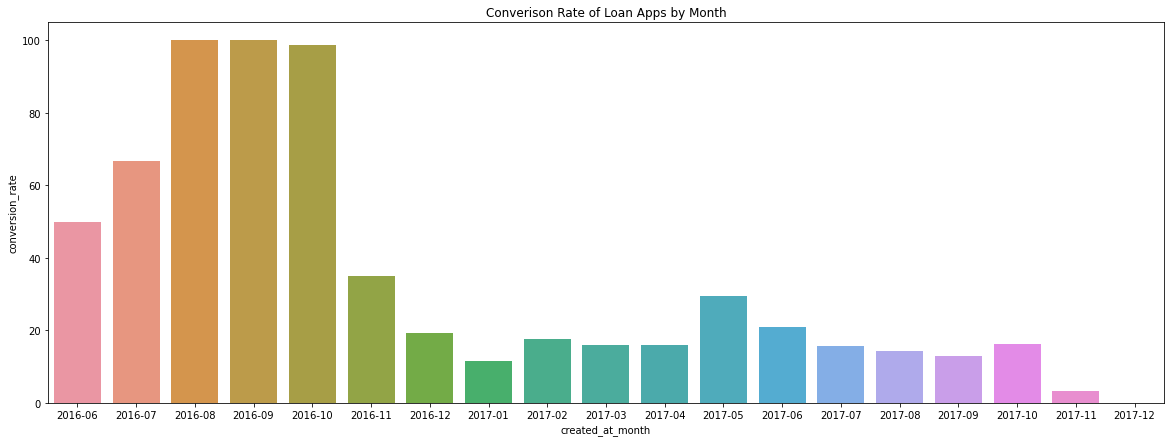

In [48]:
fig  = plt.figure(figsize=(20,7))
bp = sns.barplot(x = monthly_loan_stats.index, y =(monthly_loan_stats.conversion_rate*100))
bp.set_title('Converison Rate of Loan Apps by Month')
bp

<AxesSubplot:title={'center':'Num of Loans Funded by Month'}, xlabel='created_at_month', ylabel='loan_funded_count'>

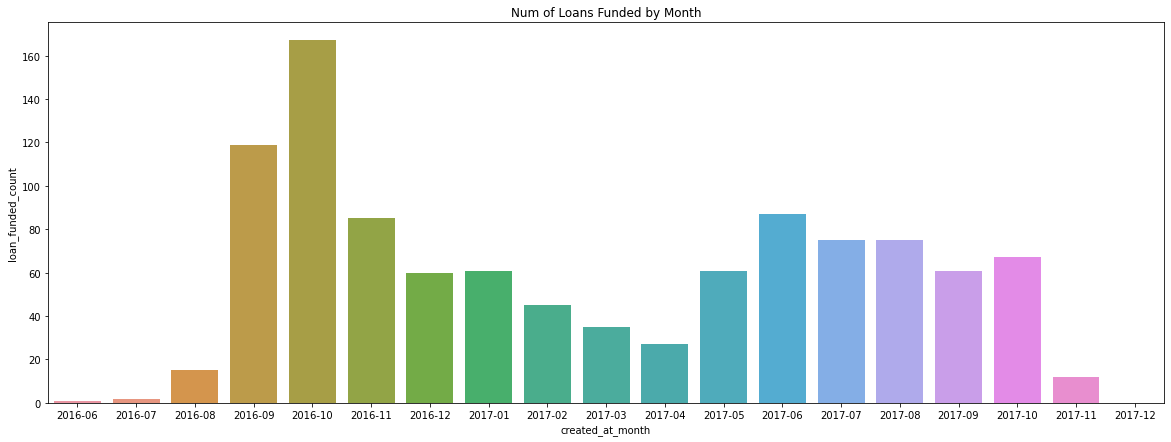

In [49]:
fig  = plt.figure(figsize=(20,7))
bp = sns.barplot(x = monthly_loan_stats.index, y =monthly_loan_stats.loan_funded_count)
bp.set_title('Num of Loans Funded by Month')
bp

<AxesSubplot:title={'center':'Num of Loan Apps by Month'}, xlabel='created_at_month', ylabel='loan_app_count'>

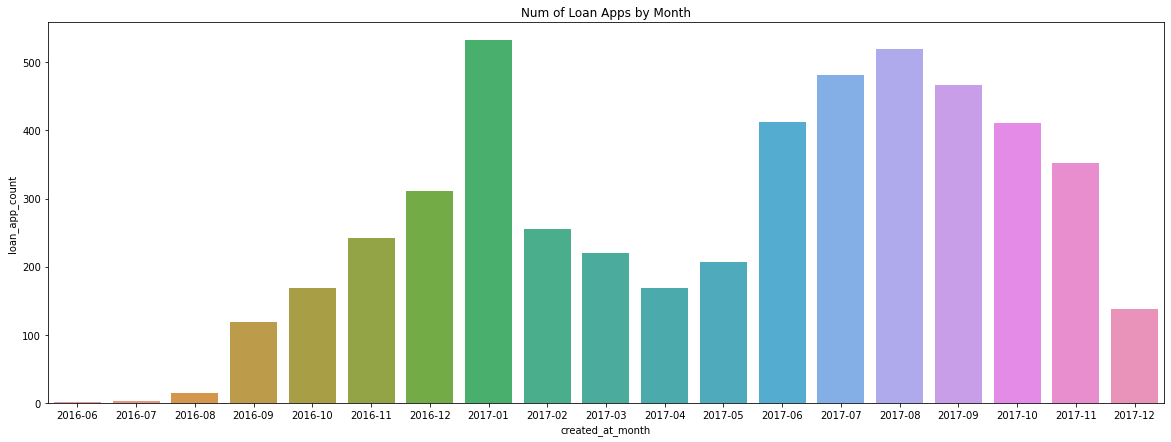

In [50]:
fig  = plt.figure(figsize=(20,7))
bp = sns.barplot(x = monthly_loan_stats.index, y =monthly_loan_stats.loan_app_count)
bp.set_title('Num of Loan Apps by Month')
bp

<AxesSubplot:title={'center':'Avg Time to Conversion by Month'}, xlabel='created_at_month', ylabel='time_to_conversion_avg'>

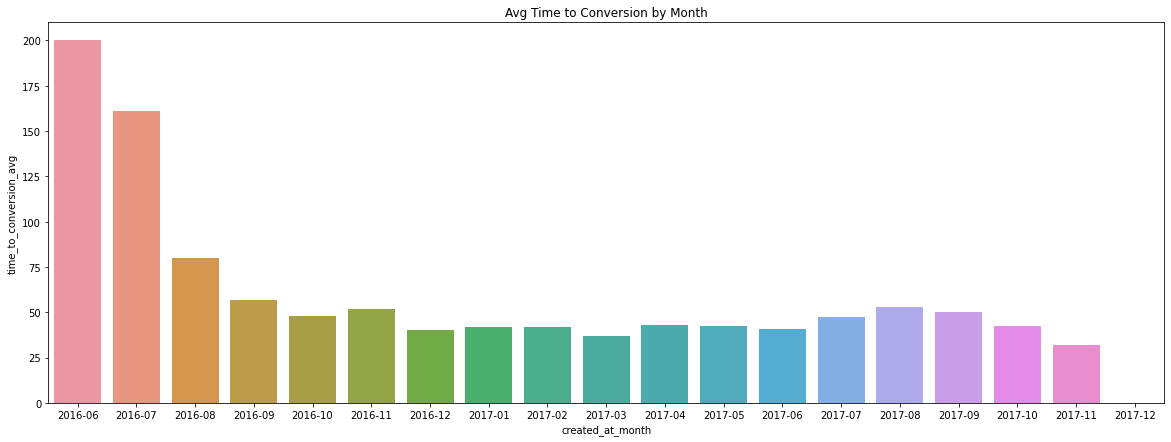

In [51]:
fig  = plt.figure(figsize=(20,7))
bp = sns.barplot(x = monthly_loan_stats.index, y =monthly_loan_stats.time_to_conversion_avg)
bp.set_title('Avg Time to Conversion by Month')
bp

### Let's generate some averages and std dev's for 2017

In [52]:
# Avg and standard deviation for conversion rate and time to conversion for 2017
metrics_2017 = monthly_loan_stats[(monthly_loan_stats.index >= '2017-01') & (monthly_loan_stats.index <= '2017-10')]

In [54]:
round(metrics_2017.time_to_conversion_avg.mean(), 3)

43.959

In [55]:
round(metrics_2017.conversion_rate.mean(), 3)

0.171

In [56]:
round(metrics_2017.time_to_conversion_avg.std(), 3)

4.834

In [57]:
round(metrics_2017.conversion_rate.std(), 3)

0.051